In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [4]:
import sys
import os
from os.path import dirname

UTILS_PATH=os.environ.get('REPO') + "/notebooks/commons"
sys.path.append(dirname(UTILS_PATH))

from commons import check_args, gen_paths
from commons import coordinates_bounds, plot_feature_importances
from commons import check_args_variables, gen_paths_variables

In [5]:
def load_posts(source_path, clean_path):
    external = pd.read_parquet(source_path)
    external.loc[:, "lat"] = external["lat"].apply(float)
    external.loc[:, "lon"] = external["lon"].apply(float)
    
    fincaraiz = pd.read_parquet(clean_path)
    return external, fincaraiz

In [6]:
if __name__ == "__main__":
    source = "PLACES"
    city = "manizales"
    
    property_type = "apartamentos"
    post_type = "venta"
    
    base_path = os.environ.get('REPO')
    
    source_path = base_path + gen_paths_variables(source, city)
    raw_path, clean_path = gen_paths(city, property_type, post_type)
        
    raw_path = base_path + raw_path
    clean_path = base_path + clean_path

In [7]:
external_variables, fincaraiz = load_posts(source_path, clean_path)

In [8]:
from math import cos, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
    """
    El resultado de la medición de distancia esta en kilometros.
    """
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))

def post_to_place_distance(publications, places, index):
    publication = publications.loc[index]
    
    places_to_point = places.copy()
    places_to_point.loc[:, "fid"] = publication["fid"]
    
    places_to_point.loc[:, "latitide"] = publication["latitude"]
    places_to_point.loc[:, "longitude"] = publication["longitude"]
    
    places_to_point.loc[:, "distance"] = places_to_point.apply(
        lambda e: distance(publication["latitude"], publication["longitude"], e["lat"], e["lon"]), axis=1)
        
    return places_to_point

import functools
from multiprocessing import Pool
def get_near_points(external_variables, fincaraiz):    
    distance_map = functools.partial(
        post_to_place_distance, 
        fincaraiz, external_variables)
    
    pool = Pool(8)
    distances = pool.map(
        distance_map,
        fincaraiz.index
    )

    return pd.concat(distances).reset_index(drop=True)

In [9]:
distances_map = get_near_points(external_variables, fincaraiz)
distances_map.head()

,lat,lon,amenity,name,fid,latitide,longitude,distance
0,5.045668,-75.528992,university,Universidad Antonio Nariño Manizales,5478594,5.059,-75.478996,5.732616
1,5.045668,-75.528992,university,UAN Universidad Antonio Nariño,5478594,5.059,-75.478996,5.732616
2,5.001526,-75.598802,university,Mànizales,5478594,5.059,-75.478996,14.729161
3,4.985796,-75.606928,university,CUN - Corporación Unificada Nacional de Educac...,5478594,5.059,-75.478996,16.342258
4,4.983539,-75.605624,university,JUZGADO PRIMERO PROMISCUO MUNICIPAL DE CHINCHINÁ,5478594,5.059,-75.478996,16.344626


In [10]:
distances_map.loc[distances_map["distance"] == distances_map["distance"].min()]

,lat,lon,amenity,name,fid,latitide,longitude,distance
34060,5.070275,-75.513817,university,Yerly natalia López Acevedo,4669095,5.070275,-75.513817,0.0
34061,5.070275,-75.513817,university,Colegio de Jueces y Fiscales de Caldas,4669095,5.070275,-75.513817,0.0
34090,5.070275,-75.513817,shopping_mall,Auditorio unicentro estrella,4669095,5.070275,-75.513817,0.0
34091,5.070275,-75.513817,shopping_mall,El cable plaza,4669095,5.070275,-75.513817,0.0
34092,5.070275,-75.513817,shopping_mall,Ley sancancio,4669095,5.070275,-75.513817,0.0
...,...,...,...,...,...,...,...,...
7686243,5.070275,-75.513817,restaurant,"CLUB: NUTRICION ,SALUD, BIENESTAR, TERMOMASAJES",4668763,5.070275,-75.513817,0.0
7686244,5.070275,-75.513817,restaurant,Algussto Manizales,4668763,5.070275,-75.513817,0.0
7686245,5.070275,-75.513817,restaurant,villa pilar hamburguesas,4668763,5.070275,-75.513817,0.0
7686246,5.070275,-75.513817,restaurant,Restaurantes chinos,4668763,5.070275,-75.513817,0.0


In [11]:
## Un punto de interes es cercano a la publicicación cuando esta a menos de 3 kilometros

near_points = distances_map.loc[distances_map["distance"] < 3]
near_points.head()

,lat,lon,amenity,name,fid,latitide,longitude,distance
105,5.040884,-75.498227,secondary_school,Liceo Mixto Aranjuez,5478594,5.059,-75.478996,2.931712
117,5.042459,-75.499351,police,CAI Aranjuez,5478594,5.059,-75.478996,2.909693
156,5.053020,-75.505044,park,Camilo Torres Park,5478594,5.059,-75.478996,2.960751
158,5.050831,-75.503086,park,Jose Restrepo Park,5478594,5.059,-75.478996,2.818577
202,5.056053,-75.504015,local_government_office,Cootransnorcaldas,5478594,5.059,-75.478996,2.790444


In [12]:
near_points.describe()

,lat,lon,latitide,longitude,distance
count,3.861038e+06,3.861038e+06,3.861038e+06,3.861038e+06,3.861038e+06
mean,5.060535e+00,-7.550020e+01,5.059561e+00,-7.549920e+01,1.678848e+00
std,1.018048e-02,1.531901e-02,9.911940e-03,1.544290e-02,7.869402e-01
min,5.006504e+00,-7.556671e+01,5.027696e+00,-7.554888e+01,0.000000e+00
25%,5.053965e+00,-7.551366e+01,5.051657e+00,-7.551139e+01,1.044330e+00
50%,5.062292e+00,-7.549911e+01,5.060166e+00,-7.549689e+01,1.699011e+00
75%,5.067488e+00,-7.548843e+01,5.066400e+00,-7.548704e+01,2.359246e+00
max,5.116710e+00,-7.542547e+01,5.097740e+00,-7.544824e+01,3.000000e+00


In [13]:
near_points_by_categories = near_points[["fid", "amenity", "name"]].groupby(["fid", "amenity"]).count()
near_points_by_categories.head()

name
fid     amenity             
1995924 amusement_park     1
        bank             107
        church            63
        hospital          57
        library           12

In [14]:
index = list(zip(*near_points_by_categories.index))
near_points_by_categories.loc[:, "fid"] = index[0]
near_points_by_categories.loc[:, "amenity"] = index[1]
near_points_by_categories.loc[:, "count"] = near_points_by_categories["name"]

near_points_by_categories = near_points_by_categories.reset_index(drop=True)
near_points_by_categories = near_points_by_categories.drop(["name"], axis=1)
near_points_by_categories.head()

,fid,amenity,count
0,1995924,amusement_park,1
1,1995924,bank,107
2,1995924,church,63
3,1995924,hospital,57
4,1995924,library,12


In [15]:
posts_full = fincaraiz[["fid"]].copy()
posts_full = posts_full.drop_duplicates(["fid"])

def safe_get(post, amenity):
    client = near_points_by_categories.loc[
        near_points_by_categories["fid"] == post["fid"]]
    
    if client.shape[0] == 0:
        return 0
    
    client = client.loc[client["amenity"] == amenity]
    if client.shape[0] == 0:
        return 0
    
    return client["count"].iloc[0]

In [16]:
for amenity in external_variables["amenity"].value_counts().index:
    posts_full.loc[:, amenity] = posts_full.apply(lambda e: safe_get(e, amenity), axis=1)

In [17]:
posts_full["airport"].describe()

count    3004.000000
mean        0.181092
std         0.385158
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: airport, dtype: float64

In [18]:
## Las features y las etiquetas son las mismas en todos los métodos

FEATURES = list(filter(lambda e: e != "fid", posts_full.columns))
LABEL = "price"

final_features = pd.merge(posts_full, fincaraiz[["fid", "price"]], on="fid")

X = final_features[FEATURES].values
y = final_features[LABEL].values

## Selección de features univariada

In [19]:
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)
X_new.shape

(3004, 5)

In [20]:
feature_importances = pd.DataFrame({'importance': selector.scores_, 'feature': FEATURES})

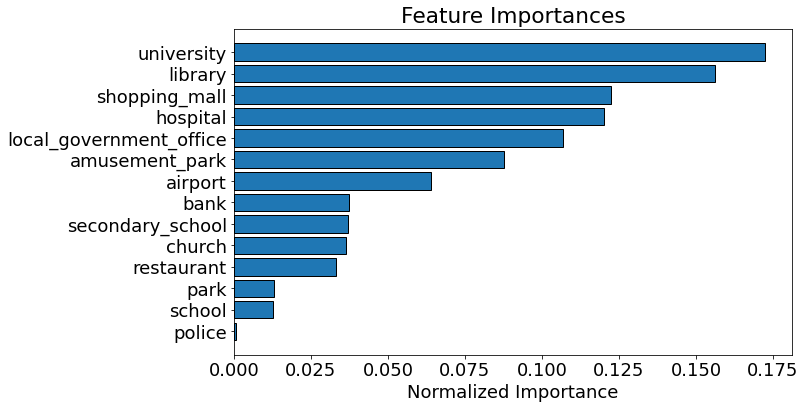

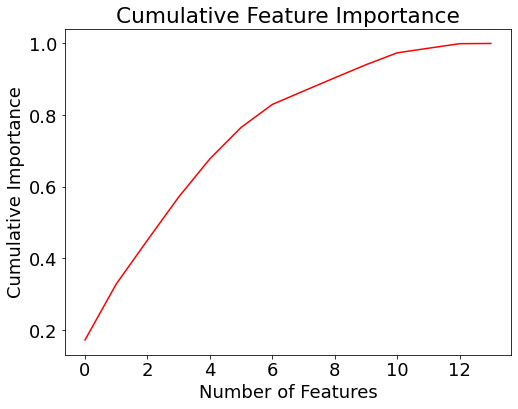

9 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,7,115.872801,university,0.172535,0.172535
1,11,104.798500,library,0.156045,0.328581
2,5,82.258331,shopping_mall,0.122483,0.451064
3,6,80.750069,hospital,0.120237,0.571301
4,8,71.690350,local_government_office,0.106747,0.678048
5,12,58.866598,amusement_park,0.087653,0.765701
6,13,43.063101,airport,0.064121,0.829822
7,2,25.071227,bank,0.037331,0.867153
8,10,24.874457,secondary_school,0.037038,0.904191
9,3,24.480618,church,0.036452,0.940643


In [21]:
plot_feature_importances(feature_importances)

## Eliminación recursiva de features

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [23]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.11110533953944213

In [24]:
rfe = RFE(estimator=reg, n_features_to_select=1, step=1)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [25]:
feature_importances = pd.DataFrame({'importance': rfe.ranking_, 'feature': FEATURES})

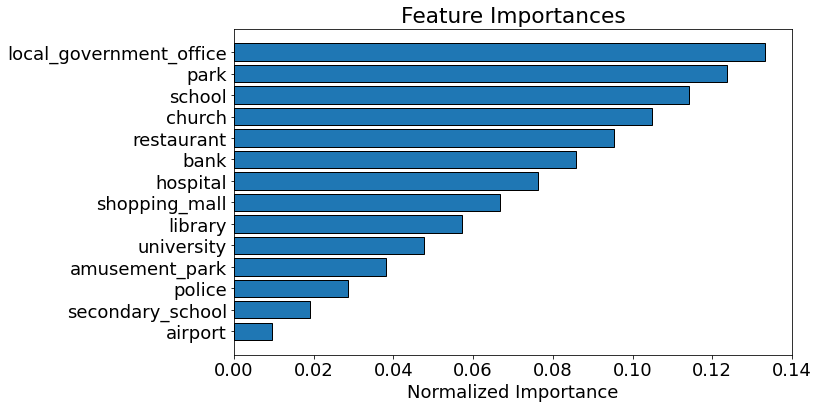

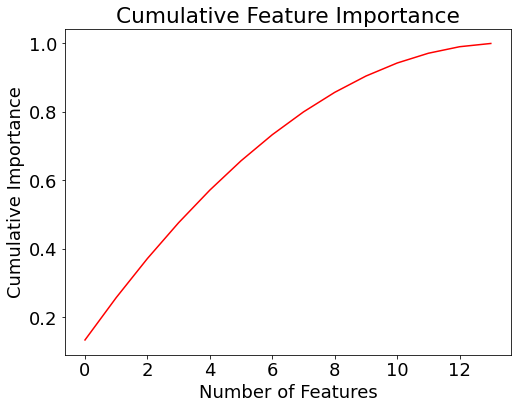

10 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,8,14,local_government_office,0.133333,0.133333
1,4,13,park,0.123810,0.257143
2,1,12,school,0.114286,0.371429
3,3,11,church,0.104762,0.476190
4,0,10,restaurant,0.095238,0.571429
5,2,9,bank,0.085714,0.657143
6,6,8,hospital,0.076190,0.733333
7,5,7,shopping_mall,0.066667,0.800000
8,11,6,library,0.057143,0.857143
9,7,5,university,0.047619,0.904762


In [26]:
plot_feature_importances(feature_importances)

## Selección de features basada en arboles

In [27]:
from sklearn.ensemble import ExtraTreesRegressor

In [28]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(X, y)

ExtraTreesRegressor(random_state=0)

In [29]:
feature_importances = pd.DataFrame({'importance':  forest.feature_importances_, 'feature': FEATURES})

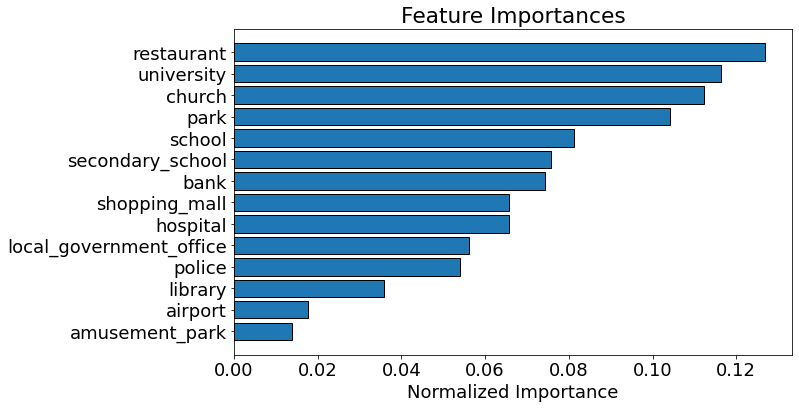

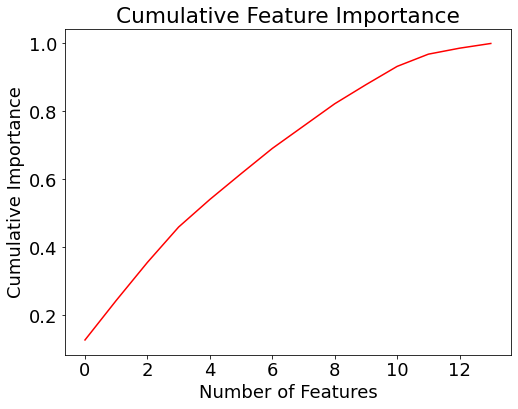

11 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,0,0.126943,restaurant,0.126943,0.126943
1,7,0.116318,university,0.116318,0.243261
2,3,0.112178,church,0.112178,0.355439
3,4,0.104071,park,0.104071,0.459510
4,1,0.081195,school,0.081195,0.540706
5,10,0.075800,secondary_school,0.075800,0.616505
6,2,0.074409,bank,0.074409,0.690915
7,5,0.065809,shopping_mall,0.065809,0.756723
8,6,0.065758,hospital,0.065758,0.822481
9,8,0.056174,local_government_office,0.056174,0.878654


In [30]:
plot_feature_importances(feature_importances)